# Fater Transfer(Model-Optimization-Based)

### Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from collections import defaultdict
from tqdm import tqdm
import random
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Use GPU if available

In [2]:
# use GPU in colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Connect to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -rf /usr/local/lib/python2.7
!rm -rf /swift

### Preprocess Data
Preprocess the image

In [5]:
# define the desired resizing size
imsize = 512 

"""
VGG19 are trained on images with each channel normalized by 
mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
Use them to normalize the image before inputting it to the network
"""
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5


# build a function to preprocess, open and load image data
def image_loader(path):
  # use Compose to merge image preprocessing steps together
    loader = transforms.Compose([
          transforms.Resize((imsize,imsize)), # resize the image into the same size
          transforms.CenterCrop(imsize), # chop the image to the same size
          transforms.ToTensor(), # transform it into a torch tensor
          tensor_normalizer, # normalize it to fit VGG19
      ])
    image = Image.open(path) # open image from the specified path
    image = loader(image).unsqueeze(0) # fake batch dimension required to fit network's input dimensions
    return image.to(device, torch.float)

Reconvert a copy of it to PIL format for display.

In [6]:
unloader = transforms.ToPILImage()  # convert a tensor to PIL image
plt.ion() # open interactive mode


# build a function to get PIL image
def image_unloader(tensor):
    image = tensor.detach().cpu().numpy() # detach the tensor
    # unnormalize the results
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]

# reconvert PIL format image during the process of image showing and saving
def imshow(tensor, title=None):
    image = image_unloader(tensor)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def imsave(tensor, path, name):
    output_img = image_unloader(tensor)
    output_img.save(path+name,'JPEG') # specify the path to save the output image

Moving smooth dinput data to smooth the loss.

In [7]:
# Create 'Smooth' class to moving smooth the input data
class Smooth:
    # initialize
    def __init__(self, windowsize=100): # default smooth windowsize is 100
        self.window_size = windowsize
        # generate attribute to store moving smooth results
        self.data = np.zeros((self.window_size, 1), dtype=np.float32) 
        self.index = 0
    
    def __iadd__(self, x):
      # process moving smooth
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self
    
    def __float__(self):
        return float(self.data.mean())
    
    def __format__(self, f):
        return self.__float__().__format__(f)

# Models
Use pre-trained VGG19.

In [8]:
# create 'VGG' class to train on VGG19 loss network
class VGG(nn.Module):
    # initialize
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        # specify layer need to save in output results
        self.layer_name = {
            '3': 'relu1_2',
            '8': 'relu2_2',
            '17': 'relu3_4',
            '22': 'relu4_2',
            '26': 'relu4_4',
            '35': 'relu5_4'
        }
        # Turn-off Gradient History
        for p in self.features.parameters():
            p.requires_grad = False #frozen parameters of VGG

    # get specify layers results
    def forward(self, x):
        outs = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in self.layer_name:
                outs.append(x)
        return outs

Define Conv blocks and Res blocks that will be used in Transform network.

In [9]:
class ConvLayer(nn.Module):
    # initialize
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm='instance', relu=True):
        super(ConvLayer, self).__init__()
        # Padding layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Conv Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization
        self.norm = norm
        if norm == 'instance':
            self.norm_layer = self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif norm == 'batch':
            self.norm_layer = self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

        # ReLu
        self.relu = relu
        self.relu_layer = nn.ReLU()

    # get results to output 
    def forward(self, x):
      x = self.reflection_pad(x)
      x = self.conv_layer(x)
      if self.norm:
          x = self.norm_layer(x)
      if self.relu:
          outs = self.relu_layer(x)
      else:
          outs = x

      return outs


class ResidualLayer(nn.Module):
    # initialize
    def __init__(self, channels):
      super(ResidualLayer, self).__init__()
      # Conv Layer
      self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
      self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)

    # get results to output 
    def forward(self, x):
        outs = self.conv1(x)
        outs = self.conv2(outs)
        outs = outs + x
        return outs


class ConvTLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm='instance', relu=True):
        super(ConvTLayer,self).__init__()
        # Transpose Conv Layer
        padding_size = kernel_size // 2
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization
        self.norm = norm
        if norm == 'instance':
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif norm == 'batch':
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

        # ReLu
        self.relu = relu
        self.relu_layer = nn.ReLU()
    
    # get results to output
    def forward(self, x):
        x = self.convT(x)
        if self.norm:
          x = self.norm_layer(x)
        if self.relu:
            outs = self.relu_layer(x)
        else:
            outs = x

        return outs

Construct Transform Net

In [10]:
class TransformNet(nn.Module):
    def __init__(self, base=32, tanh=True, tanh_mult=150):
        super(TransformNet, self).__init__()
        # Conv layer block
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, base, kernel_size=9, stride=1),
            ConvLayer(base, base*2, kernel_size=3, stride=2), 
            ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        # res layer block
        self.ResidualBlock = nn.Sequential(
            *[ResidualLayer(base*4) for i in range(5)]
            )
        # conv transpose layer block
        self.ConvTBlock = nn.Sequential(
            ConvTLayer(base*4, base*2, kernel_size=3, stride=2, output_padding=1),
            ConvTLayer(base*2, base, kernel_size=3, stride=2, output_padding=1),
            ConvLayer(base, 3, kernel_size=9, stride=1, norm=False, relu=False)
        )
        # activation
        self.tanh = tanh
        self.tanh_mult = tanh_mult
        self.TanhBlock = nn.Sequential(nn.Tanh())

    # get results to output
    def forward(self,x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        x = self.ConvTBlock(x)
        if self.tanh:
          outs = self.TanhBlock(x) * self.tanh_mult
        else:
          outs = x
        
        return outs

# Load Style Image and Training Data

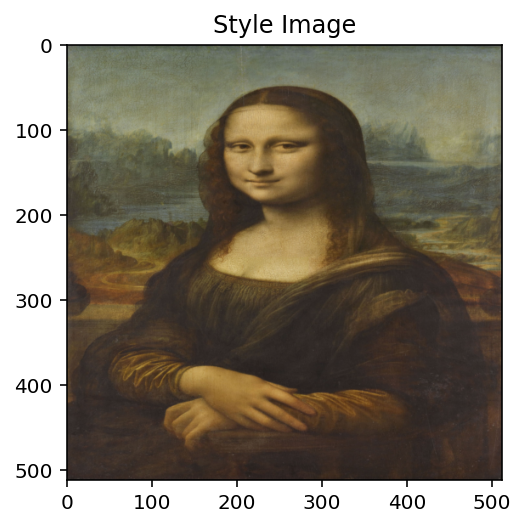

In [12]:
style_path ="/content/drive/MyDrive/590-project/Style/"
style = ["Edvard Munch - The Scream",
         "Katsushika Hokusai - The Great Wave off Kanagawa",
         "Vincent Van Gogh - The Starry Night",
         "Claude Monet - Water-Lilies (1916)",
         "Leonardo Da Vinci - Portrait of Lisa Gherardini",
         "Leonid Afremov - Rain Princess"]
style_path = style_path + style[4] + '.jpg'
style_img = image_loader(style_path).to(device)
imshow(style_img, title='Style Image')

Import pretrained VGG19 network.

In [13]:
vgg19 = models.vgg19(pretrained=True)
vgg19 = VGG(vgg19.features[:36]).to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Build gram matrix function to calculate.

In [14]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

Load training data from LabelMe dataset.

In [15]:
# parameters
batch_size = 1
width = 256

# use Compose to merge image preprocessing steps together
data_transform = transforms.Compose([
    transforms.Resize(width), 
    transforms.CenterCrop(width), 
    transforms.ToTensor(), 
    tensor_normalizer, 
])

# load data
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/590-project/subset", transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset

Dataset ImageFolder
    Number of datapoints: 21000
    Root location: /content/drive/MyDrive/590-project/subset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Calculate the Gram matrix of style image.

In [16]:
style_features = vgg19(style_img)
style_grams = [gram_matrix(x) for x in style_features]
style_grams = [x.detach() for x in style_grams]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512])]

### Training

In [17]:
 # add Tanh as activation function
transform_net = TransformNet(base=32, tanh=False).to(device)

In [18]:
%mkdir -p debug

def tensor_to_array(tensor):
    x = tensor.cpu().detach().numpy()
    x = (x*255).clip(0, 255).transpose(0, 2, 3, 1).astype(np.uint8)
    return x

def save_debug_image(style_images, content_images, transformed_images, filename):
    style_image = Image.fromarray(image_unloader(style_images))
    content_images = [image_unloader(x) for x in content_images]
    transformed_images = [image_unloader(x) for x in transformed_images]
    
    new_im = Image.new('RGB', (style_image.size[0] + (width + 5) * 4, max(style_image.size[1], width*2 + 5)))
    new_im.paste(style_image, (0,0))
    
    x = style_image.size[0] + 5
    for i, (a, b) in enumerate(zip(content_images, transformed_images)):
        new_im.paste(Image.fromarray(a), (x + (width + 5) * i, 0))
        new_im.paste(Image.fromarray(b), (x + (width + 5) * i, width + 5))
    
    new_im.save(filename)

In [19]:
# parameters
verbose_batch = 800
style_weight = 1e5
content_weight = 1
tv_weight = 1e-6

# optimizer
optimizer = optim.Adam(transform_net.parameters(), 1e-3)

# start training
transform_net.train()

n_batch = len(data_loader)

content_loss_lst = []
style_loss_lst = []
tv_loss_lst = []
total_loss_lst = []

for epoch in range(1):
    print('Epoch: {}'.format(epoch+1))
    smooth_content_loss = Smooth()
    smooth_style_loss = Smooth()
    smooth_tv_loss = Smooth()
    smooth_loss = Smooth()
    with tqdm(enumerate(data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            optimizer.zero_grad()

            # use style transform model to predict transformed images
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)
            transformed_images = transformed_images.clamp(-3, 3)

            # calculate features through VGG19
            content_features = vgg19(content_images)
            transformed_features = vgg19(transformed_images)

            # get content loss
            content_loss = content_weight * F.mse_loss(transformed_features[1], content_features[1])
            content_loss_lst.append(content_loss)

            # get tv loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
            tv_loss_lst.append(tv_loss)

            # get style loss
            style_loss = 0.
            transformed_grams = [gram_matrix(x) for x in transformed_features]
            for transformed_gram, style_gram in zip(transformed_grams, style_grams):
                style_loss += style_weight * F.mse_loss(transformed_gram, 
                                                        style_gram.expand_as(transformed_gram))
            style_loss_lst.append(style_loss)
            
            # add three parts loss together
            loss = style_loss + content_loss + tv_loss
            total_loss_lst.append(loss)
            loss.backward()
            optimizer.step()

            # define print content of tqdm process bar
            smooth_content_loss += content_loss.item()
            smooth_style_loss += style_loss.item()
            smooth_tv_loss += tv_loss.item()
            smooth_loss += loss.item()
            
            s = f'Content: {smooth_content_loss:.2f} '
            s += f'Style: {smooth_style_loss:.2f} '
            s += f'TV: {smooth_tv_loss:.4f} '
            s += f'Loss: {smooth_loss:.2f}'
            if batch % verbose_batch == 0:
                s = '\n' + s
                save_debug_image(style_img, content_images, transformed_images, 
                                 f"debug/s2_{epoch}_{batch}.jpg")
            
            pbar.set_description(s)
    #torch.save(transform_net.state_dict(), 'transform_net.pth')

Epoch: 1


  0%|          | 0/21000 [00:00<?, ?it/s]
Content: 7.20 Style: 15.40 TV: 0.1768 Loss: 22.78:   0%|          | 0/21000 [00:00<?, ?it/s]
Content: 2.67 Style: 0.55 TV: 0.0384 Loss: 3.26:   4%|▍         | 799/21000 [01:07<26:59, 12.48it/s]
Content: 2.71 Style: 0.55 TV: 0.0384 Loss: 3.30:   4%|▍         | 799/21000 [01:08<26:59, 12.48it/s]
Content: 2.26 Style: 0.50 TV: 0.0298 Loss: 2.78:   8%|▊         | 1599/21000 [02:12<25:23, 12.73it/s]
Content: 2.25 Style: 0.50 TV: 0.0298 Loss: 2.78:   8%|▊         | 1599/21000 [02:12<25:23, 12.73it/s]
Content: 1.29 Style: 0.44 TV: 0.0234 Loss: 1.75: 100%|██████████| 21000/21000 [27:35<00:00, 12.68it/s]


In [20]:
# save trained model
torch.save(transform_net.state_dict(), '/content/drive/MyDrive/590-project/transform_net_Portrait.pth')

### Model Results Display

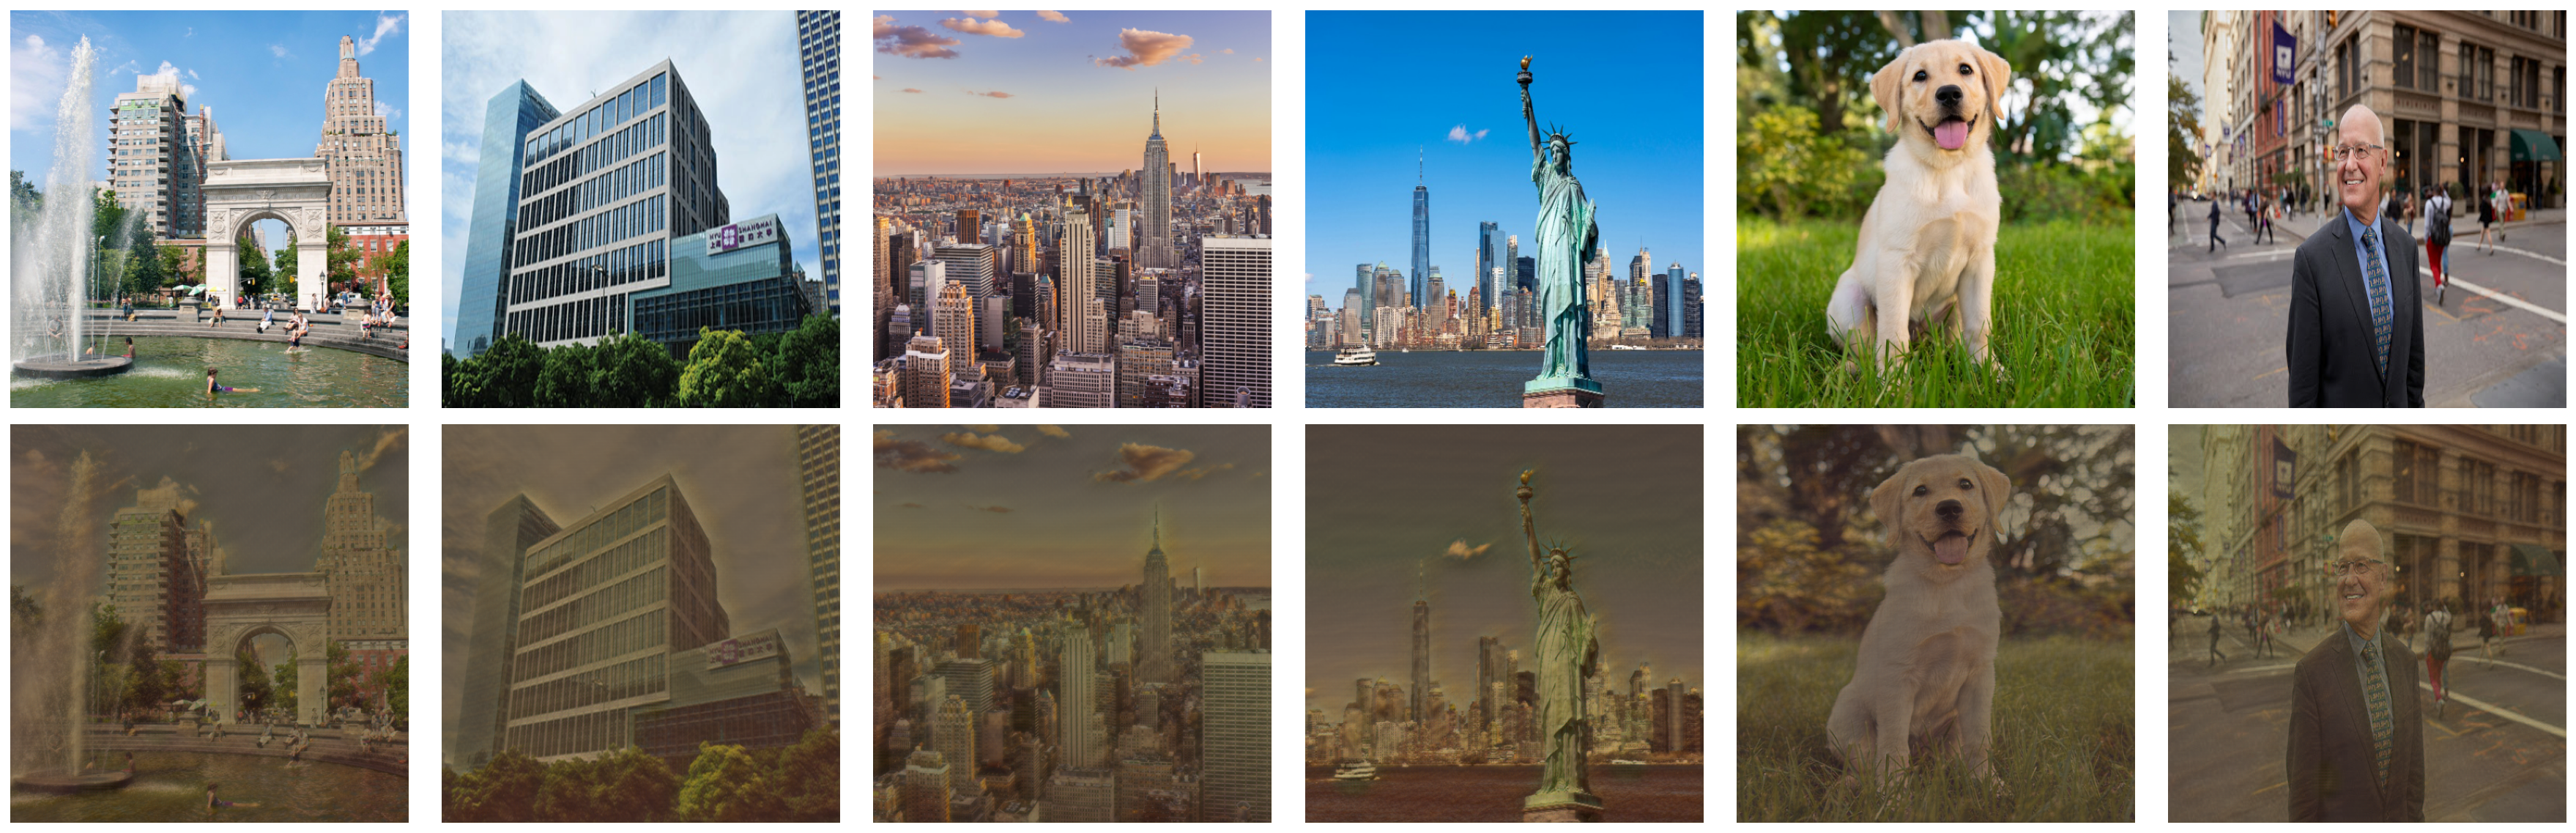

In [21]:
runtime = []
content = ['washington-square-park',
           'nyush',
           'ny', 'ny1',
           'dog','andrew hamilton']
content_img_unloaded = []
output_img_unloaded = []
for i in range(len(content)):
    start_time = time.time()
    content_img = image_loader("/content/drive/MyDrive/590-project/Test/"+content[i]+'.jpeg').to(device)
    output_img = transform_net(content_img)
    end_time = time.time()
    content_img_unloaded.append(image_unloader(content_img))
    output_img_unloaded.append(image_unloader(output_img))
    runtime.append(end_time-start_time)
plt.figure(figsize=(25,8))
total = content_img_unloaded + output_img_unloaded
for i in range(1, len(total)+1):
    plt.subplot(2,len(style),i)
    plt.imshow(total[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/590-project/Result/Portrait.png')
plt.show()

In [22]:
# print runtime
np.array(runtime).mean()

0.10143693288167317

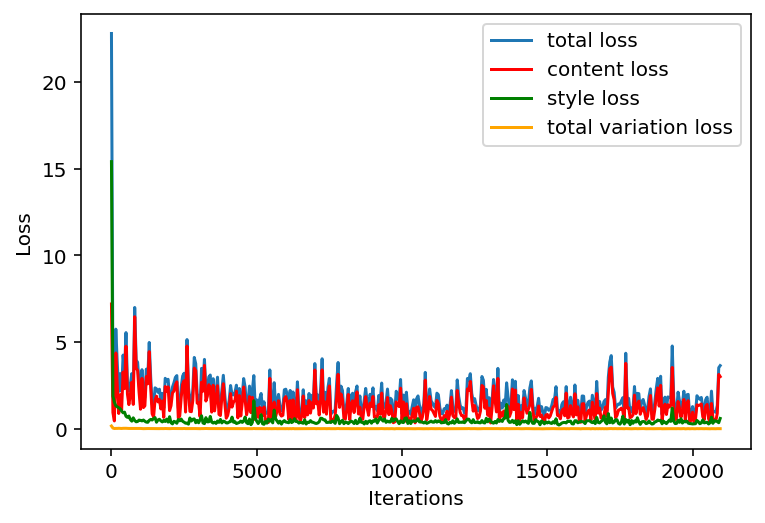

In [23]:
# plot loss descent process during training
plt.plot(range(0, len(content_loss_lst),50),[total_loss_lst[i].cpu().detach().numpy() for i in range(0, len(content_loss_lst),50)],label='total loss')
plt.plot(range(0, len(content_loss_lst),50),[content_loss_lst[i].cpu().detach().numpy() for i in range(0, len(content_loss_lst),50)], color='r',label='content loss')
plt.plot(range(0, len(content_loss_lst),50),[style_loss_lst[i].cpu().detach().numpy() for i in range(0, len(content_loss_lst),50)], color='g',label='style loss')
plt.plot(range(0, len(content_loss_lst),50),[tv_loss_lst[i].cpu().detach().numpy() for i in range(0, len(content_loss_lst),50)], color='orange',label='total variation loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig(f'/content/drive/MyDrive/590-project/Result/Portrait-loss.png')